In [11]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Attention #from attention import Attention

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix


##https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [12]:
print(f"Tensor Flow Version: {tf.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
GPU is available


In [13]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('12w_features.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

df_stable['tfi_diff_6w'] = df_stable.iloc[:,17] - df_stable.iloc[:,25] #df_stable.columns.get_loc("tfi_total.2") -->25
df_stable['tfi_diff_12w'] = df_stable.iloc[:,17] - df_stable.iloc[:,33]

df_stable['label_6w'] = np.where(df_stable['tfi_diff_6w']>=13, 1, 0)
df_stable['label_12w'] = np.where(df_stable['tfi_diff_12w']>=13, 1, 0)

df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))

31
30


/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_83089/107019627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stable['tfi_diff_6w'] = df_stable.iloc[:,17] - df_stable.iloc[:,25] #df_stable.columns.get_loc("tfi_total.2") -->25
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_83089/107019627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stable['tfi_diff_12w'] = df_stable.iloc[:,17] - df_stable.iloc[:,33]
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_83089/10

In [14]:
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total','c_3.1','sl_1.1','a_2.1','q_1.1','tfi_total.1','c_3.2','sl_1.2','a_2.2','q_1.2','tfi_total.2','tfi_total.3','label_6w','label_12w']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total','sl_2.1','r_1.1','e_1.1','tfi_total.1','sl_2.2','r_1.2','e_1.2','tfi_total.2','tfi_total.3','label_6w','label_12w']])

In [15]:
US_responders = (df_stable_US['label_12w'] == 1).sum()
US_non_responders = (df_stable_US['label_12w'] == 0).sum()
WN_responders = (df_stable_WN['label_12w'] == 1).sum()
WN_non_responders = (df_stable_WN['label_12w'] == 0).sum()
print("\n")
print('US_responders:', US_responders)
print('US_non_responders:', US_non_responders)
print("\n")
print('WN_responders:', WN_responders)
print('WN_non_responders:', WN_non_responders)



US_responders: 20
US_non_responders: 11


WN_responders: 13
WN_non_responders: 17


In [16]:
n_timesteps=3
n_features_US=5
n_features_WN=4
lr=0.001

def data_prep(df):
     
    X=df.drop(['label_6w','label_12w','tfi_total.3'],axis=1).values
    y=df[['label_12w']].values
    print(X.shape,y.shape)
    return X,y

In [17]:
def mlp(df):
    X,y=data_prep(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    K.clear_session
    model = keras.Sequential([

        keras.layers.Flatten(input_shape=(X_train.shape[1],)),

        keras.layers.Dense(16, activation=tf.nn.relu),

        keras.layers.Dense(16, activation=tf.nn.relu),

        keras.layers.Dense(1, activation=tf.nn.sigmoid),

    ])

    model.compile(optimizer='adam',

                  loss='binary_crossentropy',

                  metrics=['accuracy'])


    model.fit(X_train, y_train, epochs=100, batch_size=1)


    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    y_pred = model.predict(X_test)
    print(y_test)
    y_pred = np.round(y_pred).astype(int)
    print(y_pred)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    return test_acc,cf_matrix

US_test_acc,US_cf_matrix=mlp(df_stable_US)
WN_test_acc,WN_cf_matrix=mlp(df_stable_WN)

(31, 15) (31, 1)
Epoch 1/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5451 - accuracy: 0.7619
Epoch 2/100
 1/21 [>.............................] - ETA: 0s - loss: 1.3568 - accuracy: 0.0000e+00

2022-06-16 10:51:46.417079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 4ms/step - loss: 0.5539 - accuracy: 0.6190
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4734 - accuracy: 0.8095
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4413 - accuracy: 0.7143
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5117 - accuracy: 0.7619
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4626 - accuracy: 0.8095
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4280 - accuracy: 0.7619
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.9048
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4225 - accuracy: 0.7143
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4502 - accuracy: 0.7143
Epoch 11/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4215 - accuracy: 0.7143
Epoch 12/100
21/21 [

21/21 [==============================] - 0s 4ms/step - loss: 0.1434 - accuracy: 0.9524
Epoch 85/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1519 - accuracy: 0.9524
Epoch 86/100
21/21 [==============================] - 0s 3ms/step - loss: 0.2269 - accuracy: 0.9524
Epoch 87/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1195 - accuracy: 0.9524
Epoch 88/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.9048
Epoch 89/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9524
Epoch 90/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1423 - accuracy: 0.9524
Epoch 91/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1321 - accuracy: 0.9524
Epoch 92/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1591 - accuracy: 0.8571
Epoch 93/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1513 - accuracy: 0.9048
Epoch 94/100


2022-06-16 10:51:54.295676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:51:54.369046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 3ms/step - loss: 2.1668 - accuracy: 0.3810
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 0.9326 - accuracy: 0.3750

2022-06-16 10:51:54.527675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 3ms/step - loss: 0.8582 - accuracy: 0.4762
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7658 - accuracy: 0.6667
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7926 - accuracy: 0.5714
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.7619
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.6667
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7240 - accuracy: 0.7143
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7745 - accuracy: 0.5714
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.6190
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.5238
Epoch 11/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.7619
Epoch 12/100
21/21 [

21/21 [==============================] - 0s 4ms/step - loss: 0.3610 - accuracy: 0.8095
Epoch 85/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3685 - accuracy: 0.8095
Epoch 86/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3814 - accuracy: 0.8571
Epoch 87/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3596 - accuracy: 0.8095
Epoch 88/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 0.8571
Epoch 89/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3576 - accuracy: 0.9048
Epoch 90/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.9048
Epoch 91/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3565 - accuracy: 0.8095
Epoch 92/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4374 - accuracy: 0.8571
Epoch 93/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3498 - accuracy: 0.8095
Epoch 94/100


2022-06-16 10:52:02.474795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:52:02.546145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


US_Test accuracy: 0.800000011920929
confusion_matrix_US


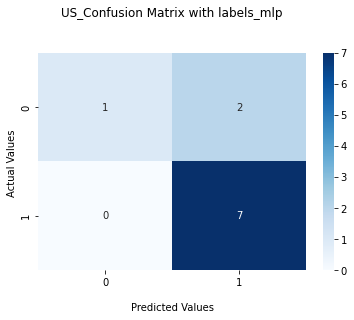

In [18]:
print('US_Test accuracy:', US_test_acc)
print("confusion_matrix_US")
ax = sns.heatmap(US_cf_matrix, annot=True, cmap='Blues')
ax.set_title('US_Confusion Matrix with labels_mlp\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

WN_Test accuracy: 0.5555555820465088
confusion_matrix_WN


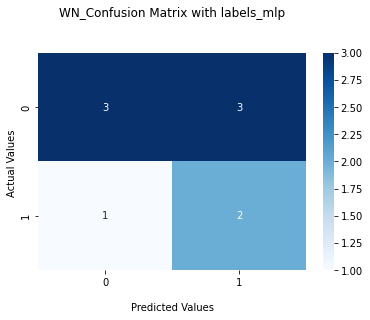

In [19]:
print('WN_Test accuracy:', WN_test_acc)
print("confusion_matrix_WN")
ax = sns.heatmap(WN_cf_matrix, annot=True, cmap='Blues')
ax.set_title('WN_Confusion Matrix with labels_mlp\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [21]:
def lstm_model(df,n_features):
    X,y=data_prep(df)
    X = X.reshape((X.shape[0],n_timesteps,n_features))
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    input_shape=(n_timesteps,n_features)
    K.clear_session
    model = Sequential([
      LSTM(50, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(20, activation='relu',input_shape=input_shape),
      Dropout(0.2),
      Dense(1,kernel_initializer='normal',activation = 'sigmoid')                      
    ])             

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    history=model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=16,
        
    )
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    y_pred = model.predict(x_test)
    print(y_test)
    y_pred = np.round(y_pred).astype(int)
    print(y_pred)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    return test_acc,cf_matrix

US_test_acc_lstm,US_cf_matrix_lstm=lstm_model(df_stable_US,n_features_US)
WN_test_acc_lstm,WN_cf_matrix_lstm=lstm_model(df_stable_WN,n_features_WN)

(31, 15) (31, 1)
Epoch 1/100


2022-06-16 10:52:33.613497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 97ms/step - loss: 0.6689 - accuracy: 0.6190
Epoch 2/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6885 - accuracy: 0.5714
Epoch 3/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6516 - accuracy: 0.6190
Epoch 4/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6492 - accuracy: 0.7143
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 0.7201 - accuracy: 0.4762
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6974 - accuracy: 0.4762
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6776 - accuracy: 0.6190
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6097 - accuracy: 0.5714
Epoch 9/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6570 - accuracy: 0.5714
Epoch 10/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6109 - accuracy: 0.6667
Epoch 11/100
2/2 [=============

Epoch 84/100
2/2 [==============================] - 0s 39ms/step - loss: 0.1722 - accuracy: 0.9524
Epoch 85/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1234 - accuracy: 0.9524
Epoch 86/100
2/2 [==============================] - 0s 40ms/step - loss: 0.2034 - accuracy: 0.8571
Epoch 87/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0995 - accuracy: 0.9524
Epoch 88/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1023 - accuracy: 1.0000
Epoch 89/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0605 - accuracy: 1.0000
Epoch 90/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0968 - accuracy: 0.9524
Epoch 91/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0314 - accuracy: 1.0000
Epoch 92/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1881 - accuracy: 0.9048
Epoch 93/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0718 - accuracy: 0.9524
Epoch 94/1

2022-06-16 10:52:42.560137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:52:42.748149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.0587443113327026
Test accuracy: 0.800000011920929
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]]
(30, 12) (30, 1)
Epoch 1/100


2022-06-16 10:52:43.725992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 88ms/step - loss: 0.6938 - accuracy: 0.4286
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6898 - accuracy: 0.5238
Epoch 3/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6808 - accuracy: 0.5238
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6916 - accuracy: 0.6190
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7044 - accuracy: 0.4286
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6846 - accuracy: 0.5714
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6811 - accuracy: 0.5238
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6802 - accuracy: 0.7143
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: 0.7159 - accuracy: 0.4762
Epoch 10/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7155 - accuracy: 0.3810
Epoch 11/100
2/2 [=============

Epoch 84/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3261 - accuracy: 0.9048
Epoch 85/100
2/2 [==============================] - 0s 41ms/step - loss: 0.4364 - accuracy: 0.8571
Epoch 86/100
2/2 [==============================] - 0s 39ms/step - loss: 0.4520 - accuracy: 0.7143
Epoch 87/100
2/2 [==============================] - 0s 39ms/step - loss: 0.2370 - accuracy: 0.9524
Epoch 88/100
2/2 [==============================] - 0s 39ms/step - loss: 0.2578 - accuracy: 0.9524
Epoch 89/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3314 - accuracy: 0.8571
Epoch 90/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3774 - accuracy: 0.8095
Epoch 91/100
2/2 [==============================] - 0s 40ms/step - loss: 0.2848 - accuracy: 0.8095
Epoch 92/100
2/2 [==============================] - 0s 40ms/step - loss: 0.4267 - accuracy: 0.8095
Epoch 93/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3837 - accuracy: 0.8571
Epoch 94/1

2022-06-16 10:52:52.417102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.7953518033027649
Test accuracy: 0.7777777910232544
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]


2022-06-16 10:52:52.622697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


US_Test accuracy: 0.800000011920929
confusion_matrix_US


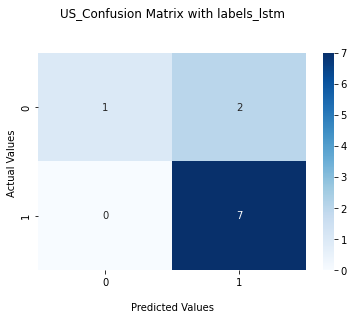

In [24]:
print('US_Test accuracy:', US_test_acc_lstm)
print("confusion_matrix_US")
ax = sns.heatmap(US_cf_matrix_lstm, annot=True, cmap='Blues')
ax.set_title('US_Confusion Matrix with labels_lstm\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

WN_Test accuracy: 0.7777777910232544
confusion_matrix_WN


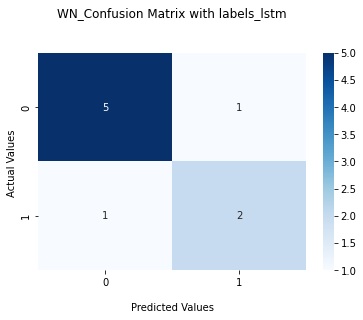

In [25]:
print('WN_Test accuracy:', WN_test_acc_lstm)
print("confusion_matrix_WN")
ax = sns.heatmap(WN_cf_matrix_lstm, annot=True, cmap='Blues')
ax.set_title('WN_Confusion Matrix with labels_lstm\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [27]:
cv = LeaveOneOut()


error_scores_US=[]
error_scores_WN=[]
#kfold = KFold(n_splits=5)

def mlp_model(X_train, y_train,X_test,y_test):
    #input_shape=X_train.shape[1]
    #print(input_shape)
    model = keras.Sequential([
    
    keras.layers.Flatten(input_shape=(X_train.shape[1],)), #input_shape=(15,)

    keras.layers.Dense(16, activation=tf.nn.relu),

    keras.layers.Dense(16, activation=tf.nn.relu),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),

    ])


    model.compile(optimizer='adam',

                  loss='binary_crossentropy',

                  metrics=['accuracy'])


    model.fit(X_train, y_train, epochs=100,batch_size=1)#batch_size=32
    yhat=model.predict(X_test)
    test_loss, test_acc = model.evaluate(X_test, y_test,verbose=0)
    
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    print('True Label:', y_test)
    print('Predicted Label:', yhat)
    print("\n")

    return test_acc



    #print('Test accuracy:', test_acc)

def loocv(df,n_features,error_scores):
    X,y=data_prep(df)
    #input_shape=n_timesteps,n_features
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X):
        print("TRAIN:", train_ix, "TEST:", test_ix)
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #input_shape=X_train.shape[1]
        # fit model
        test_acc= mlp_model(X_train, y_train,X_test,y_test)
        #model.fit(X_train, y_train)
        # evaluate model
        #test_loss, test_acc = model.evaluate(X_test, y_test,verbose = 0)
        # store
        error_scores.append(test_acc)
    return error_scores

US_error_scores=loocv(df_stable_US,n_features_US,error_scores_US)
WN_error_scores=loocv(df_stable_WN,n_features_WN,error_scores_WN)

(31, 15) (31, 1)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [0]
Epoch 1/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 1.5316 - accuracy: 0.0000e+00

2022-06-16 10:57:00.670936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3973 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5081 - accuracy: 0.6667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4607 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3915 - accuracy: 0.9000
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3825 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4574 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3333 - accuracy: 0.7667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0859 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0839 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0900 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:57:12.187915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:57:12.247614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.7000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.3464 - accuracy: 1.0000

2022-06-16 10:57:12.433223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4348 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4262 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4103 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4683 - accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3930 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3985 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3941 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3566 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3695 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3681 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 6ms/step - loss: 0.0629 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0670 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0575 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0557 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:57:24.654510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:57:24.727971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/30 [===================>..........] - ETA: 0s - loss: 0.7315 - accuracy: 0.6000

2022-06-16 10:57:24.960498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 5ms/step - loss: 0.6609 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5625 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.4372 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4192 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4277 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4084 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3873 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4186 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3671 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3512 - accuracy: 0.8667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1178 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0934 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0833 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1001 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 1.0000
Epoch 93/100


2022-06-16 10:57:37.720423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:57:37.779889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5640 - accuracy: 0.6667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5305 - accuracy: 1.0000

2022-06-16 10:57:37.973286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4567 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5239 - accuracy: 0.7000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4580 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4187 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3771 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3940 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3784 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.1290 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0894 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0953 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0774 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0723 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0809 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:57:49.320800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:57:49.379280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.6000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.4502 - accuracy: 1.0000

2022-06-16 10:57:49.785014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5233 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4597 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4428 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4196 - accuracy: 0.7000
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4393 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3822 - accuracy: 0.8667
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3766 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.1007 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0951 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9333
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0910 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0883 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0829 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0754 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:58:00.870795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:58:00.930573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.6030 - accuracy: 0.6333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0153 - accuracy: 1.0000

2022-06-16 10:58:01.117014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4882 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4283 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3758 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3530 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3826 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3800 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3446 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3860 - accuracy: 0.7667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 5ms/step - loss: 0.1094 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1084 - accuracy: 0.9333
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0970 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1130 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0908 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0766 - accuracy: 0.9667
Epoch 94/100


2022-06-16 10:58:12.654910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:58:12.713955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5601 - accuracy: 0.6333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6650 - accuracy: 1.0000

2022-06-16 10:58:12.900876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4819 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4170 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3842 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3738 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3913 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3616 - accuracy: 0.7333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3546 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0978 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1013 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0929 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0819 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9333
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9667
Epoch 94/100


2022-06-16 10:58:24.707012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:58:24.776176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5464 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.2534 - accuracy: 1.0000

2022-06-16 10:58:24.983127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4286 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4023 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3622 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3965 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3637 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3202 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3180 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3604 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3422 - accuracy: 0.7667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.2976 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0256 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0204 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0185 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0179 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0323 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:58:36.706166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:58:36.775001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/30 [==================>...........] - ETA: 0s - loss: 0.5656 - accuracy: 0.7368

2022-06-16 10:58:36.988706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 6ms/step - loss: 0.4788 - accuracy: 0.7667
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3650 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3264 - accuracy: 0.8667
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3622 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3406 - accuracy: 0.9333
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3249 - accuracy: 0.9000
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.2811 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0828 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0526 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0549 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0484 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0774 - accuracy: 0.9667
Epoch 93/100


2022-06-16 10:58:48.704003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:58:48.764422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.8022 - accuracy: 0.6333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6730 - accuracy: 1.0000

2022-06-16 10:58:48.955646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 5ms/step - loss: 0.5158 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.4638 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4374 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4078 - accuracy: 0.7333
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3638 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4105 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4250 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3464 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0959 - accuracy: 0.9333
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0969 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0848 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:59:00.797033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:00.855807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5353 - accuracy: 0.7000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0579 - accuracy: 1.0000

2022-06-16 10:59:01.040240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4539 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4156 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4131 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0793 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0789 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0727 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:59:12.066380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:12.127109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.5667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.3806 - accuracy: 1.0000

2022-06-16 10:59:12.314834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4753 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4637 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4345 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4366 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4517 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3783 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4614 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3851 - accuracy: 0.7667
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 5ms/step - loss: 0.1354 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0708 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:59:24.684066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:24.745614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 1.7883 - accuracy: 0.0000e+00

2022-06-16 10:59:24.939884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4644 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4201 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3976 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4276 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4119 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3840 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3875 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3495 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3224 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0919 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0862 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0919 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0800 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0904 - accuracy: 0.9667
Epoch 94/100


2022-06-16 10:59:36.056593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:36.118264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.7000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.3368 - accuracy: 1.0000

2022-06-16 10:59:36.311542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4267 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3920 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4332 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4521 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3448 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3451 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3365 - accuracy: 0.9000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3402 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0360 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1401 - accuracy: 0.9333
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9333
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0532 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1001 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0412 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:59:47.486784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:47.548133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.6667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

2022-06-16 10:59:47.926427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5006 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4673 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4280 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3974 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4493 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3872 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3771 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3523 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3961 - accuracy: 0.7667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0842 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0791 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0727 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0833 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 1.0000
Epoch 94/100


2022-06-16 10:59:59.088890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 10:59:59.151467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/30 [==========================>...] - ETA: 0s - loss: 0.5356 - accuracy: 0.7037

2022-06-16 10:59:59.382647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5182 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4537 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4031 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4571 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4003 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3464 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3508 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3592 - accuracy: 0.7667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 5ms/step - loss: 0.0477 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0564 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0373 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0372 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0352 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0335 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0365 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 1.0000
Epoch 93/100


2022-06-16 11:00:11.088411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:00:11.148076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5849 - accuracy: 0.6000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.3613 - accuracy: 1.0000

2022-06-16 11:00:11.336524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4348 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5360 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4271 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3612 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3920 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3767 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0512 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0469 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0586 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0459 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0424 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0498 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:00:22.410138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:00:22.482802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5395 - accuracy: 0.6333


2022-06-16 11:00:22.701935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5229 - accuracy: 0.6000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4213 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4022 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3689 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4102 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3590 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3407 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3364 - accuracy: 0.9000
Epoch 12

30/30 [==============================] - 0s 4ms/step - loss: 0.0387 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0377 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0378 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0435 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0438 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:00:34.699199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:00:34.759706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5246 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6767 - accuracy: 1.0000

2022-06-16 11:00:34.954028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5020 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4714 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4228 - accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4305 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3997 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.7333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3444 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4342 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3724 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0841 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0751 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:00:46.376166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:00:46.437234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.4525 - accuracy: 1.0000

2022-06-16 11:00:46.811688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4227 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3962 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3407 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3515 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3282 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3095 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3054 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0795 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1190 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1028 - accuracy: 0.9333
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0618 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:00:58.119776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:00:58.178141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0750 - accuracy: 1.0000

2022-06-16 11:00:58.364295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4717 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3966 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3859 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3748 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.7667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3842 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.1083 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1139 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:01:09.563253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:01:09.621880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5410 - accuracy: 0.7000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5604 - accuracy: 1.0000

2022-06-16 11:01:09.807994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4308 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4183 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3248 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3341 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3346 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3630 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3438 - accuracy: 0.8667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0739 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0731 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:01:20.992418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:01:21.052406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5848 - accuracy: 0.6667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5127 - accuracy: 1.0000

2022-06-16 11:01:21.243765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4126 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4983 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3520 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3358 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4324 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3482 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0850 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0891 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0739 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0748 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:01:32.354354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:01:32.415095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5132 - accuracy: 0.6667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1074 - accuracy: 1.0000

2022-06-16 11:01:32.606023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4421 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3977 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4444 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4826 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3852 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3699 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4095 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3881 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3398 - accuracy: 0.7667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.7333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0989 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0814 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0938 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1077 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 0.1098 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 0.1031 - accuracy: 0.9333
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0795 - accuracy: 0.9667
Epoch 94/100


2022-06-16 11:01:44.879788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:01:44.951053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/30 [=========>....................] - ETA: 0s - loss: 0.5871 - accuracy: 0.7000 

2022-06-16 11:01:45.368983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 5ms/step - loss: 0.5443 - accuracy: 0.7000
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4630 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4006 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3792 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4389 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3590 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3990 - accuracy: 0.7333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0919 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0943 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0874 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0846 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0952 - accuracy: 0.9667
Epoch 93/100


2022-06-16 11:02:00.399945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:02:00.474894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.6333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1471 - accuracy: 1.0000

2022-06-16 11:02:00.703280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.4999 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4440 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4414 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.7333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3844 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4052 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3891 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3678 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 5ms/step - loss: 0.1039 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0974 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0803 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0815 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0807 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0759 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0816 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0954 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0891 - accuracy: 0.9667
Epoch 94/100


2022-06-16 11:02:13.353840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:02:13.415015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/30 [===========>..................] - ETA: 0s - loss: 0.8133 - accuracy: 0.5833

2022-06-16 11:02:13.627893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5667
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5260 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4297 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4304 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4180 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4252 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3473 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3483 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3853 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0988 - accuracy: 0.9333
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0953 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1026 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0883 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9667
Epoch 93/100


2022-06-16 11:02:26.889666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:02:26.956770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.3745580017566681
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.6875931]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30] TEST: [27]
Epoch 1/100


2022-06-16 11:02:27.227711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 6ms/step - loss: 0.5609 - accuracy: 0.7000
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4624 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4415 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4762 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4634 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4461 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3855 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3777 - accuracy: 0.9333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4298 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.7333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0979 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0912 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0821 - accuracy: 1.0000
Epoch 93/100


2022-06-16 11:02:39.976669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:02:40.044988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/30 [=========================>....] - ETA: 0s - loss: 0.6059 - accuracy: 0.5769

2022-06-16 11:02:40.266307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4635 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4278 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4603 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5555 - accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3663 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3778 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4470 - accuracy: 0.7333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3659 - accuracy: 0.8667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 5ms/step - loss: 0.0479 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0435 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0455 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0501 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0382 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0350 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0302 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0325 - accuracy: 1.0000
Epoch 93/100


2022-06-16 11:02:51.816926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:02:51.885185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 4ms/step - loss: 0.6805 - accuracy: 0.6667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1111 - accuracy: 1.0000

2022-06-16 11:02:52.384348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5820 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4689 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.4239 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4043 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3943 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4005 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4195 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4060 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0994 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1029 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0955 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0983 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0858 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9333
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9667
Epoch 94/100


2022-06-16 11:03:04.006504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:04.068104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5521 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.7311 - accuracy: 0.0000e+00

2022-06-16 11:03:04.259355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4416 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4171 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4003 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3806 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3823 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3801 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4573 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0915 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0837 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0827 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0909 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 1.0000
Epoch 94/100


2022-06-16 11:03:15.765402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:15.825825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.6593 - accuracy: 0.5172
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 3.1401 - accuracy: 0.0000e+00

2022-06-16 11:03:16.019849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8830 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7355 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7757 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7688 - accuracy: 0.4483
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8642 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6552
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5322 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4878 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4786 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3972 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4274 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3834 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.7241
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4207 - accuracy: 0.7586
Epoch 94/100


2022-06-16 11:03:26.679636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:26.740733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.9722 - accuracy: 0.4828
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.4550 - accuracy: 1.0000

2022-06-16 11:03:26.935315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 1.1203 - accuracy: 0.4483
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8271 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8059 - accuracy: 0.4483
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7480 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.5862
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4848 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5173 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5336 - accuracy: 0.6897
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4110 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4119 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy: 0.7586
Epoch 94/100


2022-06-16 11:03:37.436397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:37.497862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.4749 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.2904 - accuracy: 1.0000

2022-06-16 11:03:37.693558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 0.7789 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8141 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8123 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7433 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7422 - accuracy: 0.4828
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.6897
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5316 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5490 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4351 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4155 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4572 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4228 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4342 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3850 - accuracy: 0.7586
Epoch 94/100


2022-06-16 11:03:48.388068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:48.448860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 1.0866 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 2.2519 - accuracy: 0.0000e+00

2022-06-16 11:03:48.875430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8041 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7308 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7336 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7346 - accuracy: 0.7586
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8518 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.7586
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6552
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.4664 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3909 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4317 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4584 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4431 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5168 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4099 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3767 - accuracy: 0.8966
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4822 - accuracy: 0.7241
Epoch 94/100


2022-06-16 11:03:59.655116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:03:59.714183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.9241 - accuracy: 0.3448
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 1.8101 - accuracy: 0.0000e+00

2022-06-16 11:03:59.901368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8391 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7241 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7683 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8318 - accuracy: 0.5172
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7514 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8678 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7312 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.5172
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4146 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4653 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5573 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4479 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5625 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4686 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4182 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4371 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3931 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4171 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:04:11.905280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:04:11.968661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/29 [=======================>......] - ETA: 0s - loss: 2.3493 - accuracy: 0.2917

2022-06-16 11:04:12.167141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 2.1150 - accuracy: 0.3103
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7918 - accuracy: 0.4828
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7399 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7767 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7849 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.7241
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.4899 - accuracy: 0.7586
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6897
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4919 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5206 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4914 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4922 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4948 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4972 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4945 - accuracy: 0.6897
Epoch 93/100


2022-06-16 11:04:23.553578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:04:23.618906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.6234 - accuracy: 0.4483
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.7766 - accuracy: 0.0000e+00

2022-06-16 11:04:23.817633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.7890 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7252 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8158 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9592 - accuracy: 0.5517
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6897
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4164 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5447 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4373 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4148 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4191 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4750 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3897 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.7586
Epoch 94/100


2022-06-16 11:04:34.514282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:04:34.575998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.7280 - accuracy: 0.5172
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 1.1258 - accuracy: 0.0000e+00

2022-06-16 11:04:34.768868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8040 - accuracy: 0.3448
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7759 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8543 - accuracy: 0.3793
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5040 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5340 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5059 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5332 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5355 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5126 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5075 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4997 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5160 - accuracy: 0.7241
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4928 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:04:45.612488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:04:45.672475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/29 [=======================>......] - ETA: 0s - loss: 2.0545 - accuracy: 0.3750

2022-06-16 11:04:46.039567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 1.9833 - accuracy: 0.3448
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7985 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7200 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5862
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 3ms/step - loss: 0.4354 - accuracy: 0.7586
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4308 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4097 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4971 - accuracy: 0.6552
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5739 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3964 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3847 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4834 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4382 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5613 - accuracy: 0.7241
Epoch 93/100


2022-06-16 11:04:58.078944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:04:58.140401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.8656 - accuracy: 0.4828
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.0622 - accuracy: 1.0000

2022-06-16 11:04:58.331422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 0.7547 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8359 - accuracy: 0.6552
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6022 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7316 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7702 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.5862
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.7586
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4146 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8966
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4528 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4426 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3844 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4421 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3589 - accuracy: 0.8621
Epoch 94/100


2022-06-16 11:05:08.920610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:05:08.981579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.4882 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 3.3221 - accuracy: 0.0000e+00

2022-06-16 11:05:09.177420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.1037 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8189 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6713 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6706 - accuracy: 0.5862
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5862
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4119 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4368 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4650 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3900 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3903 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4099 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4511 - accuracy: 0.8276
Epoch 94/100


2022-06-16 11:05:19.974928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:05:20.039952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.6077 - accuracy: 0.3793
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.2409 - accuracy: 1.0000

2022-06-16 11:05:20.241884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 0.8354 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7226 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7245 - accuracy: 0.4828
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7891 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7193 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5823 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6897
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7227 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.3488 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4942 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4417 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3590 - accuracy: 0.8966
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4351 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3842 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3193 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3386 - accuracy: 0.9310
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3467 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:05:32.336020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:05:32.401419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/29 [========================>.....] - ETA: 0s - loss: 1.5475 - accuracy: 0.6000  

2022-06-16 11:05:32.604048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.4712 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7827 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7451 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8086 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8783 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7278 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8135 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6207
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.4128 - accuracy: 0.8276
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4348 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.8621
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5070 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4627 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4218 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4440 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4344 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4464 - accuracy: 0.7586
Epoch 93/100


2022-06-16 11:05:45.080987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:05:45.148985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 1.5971 - accuracy: 0.5862
Epoch 2/100


2022-06-16 11:05:45.545247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8342 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7366 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7580 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8423 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7608 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7134 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5345 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4565 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4505 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4300 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4116 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4420 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4711 - accuracy: 0.6552
Epoch 94/100


2022-06-16 11:05:57.481450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:05:57.550907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/29 [=========================>....] - ETA: 0s - loss: 1.3279 - accuracy: 0.5385  

2022-06-16 11:05:57.758298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.2717 - accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7498 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6685 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8188 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8764 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7150 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7075 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7784 - accuracy: 0.5862
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.4825 - accuracy: 0.7931
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3894 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3976 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4839 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4069 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5045 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4052 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3805 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 5ms/step - loss: 0.3423 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4011 - accuracy: 0.8966
Epoch 93/100


2022-06-16 11:06:10.194728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:06:10.259766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/29 [======================>.......] - ETA: 0s - loss: 2.1762 - accuracy: 0.2609  

2022-06-16 11:06:10.457411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 1.9646 - accuracy: 0.2414
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0113 - accuracy: 0.4138
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7536 - accuracy: 0.4483
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7140 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6552
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5271 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5364 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5772 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4879 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5343 - accuracy: 0.6897
Epoch 90/100
29/29 [==============================] - 0s 5ms/step - loss: 0.5591 - accuracy: 0.6207
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4874 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4851 - accuracy: 0.7241
Epoch 93/100


2022-06-16 11:06:22.894671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:06:22.958113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.3215 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.2310 - accuracy: 1.0000

2022-06-16 11:06:23.157764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.7947 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5620 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7974 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6897
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7274 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4691 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5035 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5080 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4941 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5262 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4419 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4416 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 0.7241
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5886 - accuracy: 0.7241
Epoch 94/100


2022-06-16 11:06:34.616386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:06:34.683691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/29 [===========>..................] - ETA: 0s - loss: 2.3649 - accuracy: 0.5833

2022-06-16 11:06:34.947059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 1.9009 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.8527 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.9387 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7389 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6509 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6721 - accuracy: 0.6207
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.4908 - accuracy: 0.7586
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.8621
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4520 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4067 - accuracy: 0.8276
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4802 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4355 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4351 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4047 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4354 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4155 - accuracy: 0.7586
Epoch 93/100


2022-06-16 11:06:46.490409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:06:46.568831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 1.7962 - accuracy: 0.3448
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.2329 - accuracy: 1.0000

2022-06-16 11:06:47.134290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7683 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.7241
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6897
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4014 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4271 - accuracy: 0.8621
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4760 - accuracy: 0.8276
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3828 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3868 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4064 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:06:57.750802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:06:57.823803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.7226 - accuracy: 0.3448
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 1.0947 - accuracy: 0.0000e+00

2022-06-16 11:06:58.056732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.7692 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7373 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.7294 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6564 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7804 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5931 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.7241
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.3800 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3909 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3499 - accuracy: 0.8621
Epoch 88/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4254 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4278 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3888 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3915 - accuracy: 0.9310
Epoch 94/100


2022-06-16 11:07:09.540405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:07:09.602296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.4475 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 1.8139 - accuracy: 0.0000e+00

2022-06-16 11:07:09.800855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8354 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8356 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7145 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7468 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7816 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7955 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.5517
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.6897
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4426 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4387 - accuracy: 0.8621
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4615 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4484 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4311 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4337 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4316 - accuracy: 0.6897
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5107 - accuracy: 0.6897
Epoch 94/100


2022-06-16 11:07:21.903718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:07:21.972628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/29 [============>.................] - ETA: 0s - loss: 2.4858 - accuracy: 0.5385    

2022-06-16 11:07:22.181503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.6963 - accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7501 - accuracy: 0.4828
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7290 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7458 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7527 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7848 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7190 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7544 - accuracy: 0.4828
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.3679 - accuracy: 0.8276
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4646 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4053 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3763 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4170 - accuracy: 0.7931
Epoch 93/100


2022-06-16 11:07:34.743786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:07:34.808465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/29 [=========================>....] - ETA: 0s - loss: 1.8377 - accuracy: 0.4615  

2022-06-16 11:07:35.011916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.7100 - accuracy: 0.4828
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7745 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7551 - accuracy: 0.6552
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7434 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8170 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7751 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7704 - accuracy: 0.5172
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6207
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5406 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4386 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4092 - accuracy: 0.8621
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4802 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4079 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4688 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4501 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.7931
Epoch 93/100


2022-06-16 11:07:45.750797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:07:45.813158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.7204 - accuracy: 0.4138
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.4912 - accuracy: 1.0000

2022-06-16 11:07:46.201698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 0.8844 - accuracy: 0.4483
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7995 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7545 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7301 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5011 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4492 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4905 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5086 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4422 - accuracy: 0.8621
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4091 - accuracy: 0.8276
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4503 - accuracy: 0.7241
Epoch 94/100


2022-06-16 11:07:57.344823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:07:57.406126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.6265 - accuracy: 0.4828
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000

2022-06-16 11:07:57.599693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0099 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8638 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.6552
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4885 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4919 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4684 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4674 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4602 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4794 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4768 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:08:08.543540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:08:08.605188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.3348 - accuracy: 0.5172
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.3487 - accuracy: 1.0000

2022-06-16 11:08:08.799895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.9229 - accuracy: 0.4483
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7550 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5802 - accuracy: 0.6897
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6897
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 5ms/step - loss: 0.4827 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5285 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4807 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4930 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4979 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5065 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5160 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5849 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4830 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4674 - accuracy: 0.7931
Epoch 94/100


2022-06-16 11:08:20.150405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:08:20.212732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 1.5609 - accuracy: 0.4483
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.4099 - accuracy: 1.0000

2022-06-16 11:08:20.423602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.7778 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7507 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8416 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7228 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8153 - accuracy: 0.4138
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9853 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7029 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.5862
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4358 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4099 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4170 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4235 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.8276
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4563 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5317 - accuracy: 0.7241
Epoch 94/100


2022-06-16 11:08:31.428359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:08:31.491810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/29 [======================>.......] - ETA: 0s - loss: 2.0811 - accuracy: 0.3478  

2022-06-16 11:08:31.694055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 1.7635 - accuracy: 0.4138
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5956 - accuracy: 0.6897
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.4197 - accuracy: 0.7931
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8621
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4020 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4947 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8621
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8276
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4103 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8621
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3668 - accuracy: 0.8621
Epoch 93/100


2022-06-16 11:08:42.505657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:08:42.569089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 2.2737 - accuracy: 0.5172
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 2.5926 - accuracy: 0.0000e+00

2022-06-16 11:08:42.960875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 0.8465 - accuracy: 0.4483
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8008 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7707 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8024 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8203 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7805 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5172
Epoch 11/100
29/29 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.6207
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5205 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4124 - accuracy: 0.8621
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4156 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4332 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4295 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3861 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3979 - accuracy: 0.8621
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5382 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4555 - accuracy: 0.7586
Epoch 94/100


2022-06-16 11:08:54.677226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:08:54.745303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/29 [========================>.....] - ETA: 0s - loss: 2.2687 - accuracy: 0.4400

2022-06-16 11:08:54.944008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 2.0600 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9112 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7380 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7546 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8794 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7186 - accuracy: 0.5862
Epoch 11/100
29/29 [=

29/29 [==============================] - 0s 4ms/step - loss: 0.3831 - accuracy: 0.8276
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4013 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4136 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8276
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4329 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3949 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4100 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8276
Epoch 93/100


2022-06-16 11:09:07.156395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:09:07.226315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [28]:
print("US_error")
print("--------")
print(US_error_scores)
US_error=np.mean(US_error_scores)
print("\n")
print(US_error)

US_error
--------
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.7419354838709677


In [29]:
print("\n")
print("WN_error")
print("--------")
print(WN_error_scores)
WN_error=np.mean(WN_error_scores)
print("\n")
print(WN_error)



WN_error
--------
[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


0.5666666666666667


In [30]:
cv = LeaveOneOut()


error_scores_US_lstm=[]
error_scores_WN_lstm=[]
#kfold = KFold(n_splits=5)

def lstm_model_loocv(X_train, y_train,X_test,y_test,n_features):
    
    input_shape=(n_timesteps,n_features)
    K.clear_session
    model = Sequential([
      LSTM(50, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(20, activation='relu',input_shape=input_shape),
      Dropout(0.2),
      Dense(1,kernel_initializer='normal',activation = 'sigmoid')                      
    ])             

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    model.fit(X_train,y_train,epochs=100,batch_size=1)
    
    yhat=model.predict(X_test)
    test_loss, test_acc = model.evaluate(X_test, y_test,verbose=0)
    
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    print('True Label:', y_test)
    print('Predicted Label:', yhat)
    print("\n")

    return test_acc
    

def loocv_lstm(df,n_features,error_scores):
    X,y=data_prep(df)
    X = X.reshape((X.shape[0],n_timesteps,n_features))
    #input_shape=n_timesteps,n_features
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X):
        print("TRAIN:", train_ix, "TEST:", test_ix)
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #input_shape=X_train.shape[1]
        # fit model
        test_acc= lstm_model_loocv(X_train, y_train,X_test,y_test,n_features)
        #model.fit(X_train, y_train)
        # evaluate model
        #test_loss, test_acc = model.evaluate(X_test, y_test,verbose = 0)
        # store
        error_scores.append(test_acc)
    return error_scores

US_error_scores_lstm=loocv_lstm(df_stable_US,n_features_US,error_scores_US_lstm)
WN_error_scores_lstm=loocv_lstm(df_stable_WN,n_features_WN,error_scores_WN_lstm)

(31, 15) (31, 1)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [0]
Epoch 1/100


2022-06-16 11:39:04.399447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6790 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6087 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5496 - accuracy: 0.6667
Epoch 4/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4957 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.4303 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3912 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3516 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3432 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 31ms/step - loss: 0.3558 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3006 - accuracy: 0.9000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 5.3765e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 27ms/step - loss: 5.3012e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 27ms/step - loss: 4.8836e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 4.6423e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 27ms/step - loss: 4.4402e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 27ms/step - loss: 4.1789e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 4.0349e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 3.8712e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 3.6836e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 11:40:28.448981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:40:28.630239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.006493115331977606
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.0064721]]


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [1]
Epoch 1/100


2022-06-16 11:40:29.319386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 27ms/step - loss: 0.6117 - accuracy: 0.5667
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5229 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4531 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4586 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4324 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.7196 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4184 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3448 - accuracy: 0.9000
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.2954 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3236 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 27ms/step - loss: 3.5529e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 27ms/step - loss: 3.4010e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 29ms/step - loss: 3.2277e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 3.0819e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 27ms/step - loss: 2.9528e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 27ms/step - loss: 2.8276e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 2.7057e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 2.5811e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 2.4882e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 11:41:55.937786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.1729280948638916
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.15880197]]


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [2]


2022-06-16 11:41:56.147021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 11:41:57.217312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 33ms/step - loss: 0.6874 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 33ms/step - loss: 0.6128 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 33ms/step - loss: 0.5319 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 1s 32ms/step - loss: 0.4720 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 32ms/step - loss: 0.4124 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 35ms/step - loss: 0.4499 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 1s 33ms/step - loss: 0.4043 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 33ms/step - loss: 0.3684 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 35ms/step - loss: 0.3511 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 33ms/step - loss: 0.3166 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 27ms/step - loss: 7.6377e-06 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 27ms/step - loss: 7.1034e-06 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 27ms/step - loss: 6.4010e-06 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 6.1284e-06 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 27ms/step - loss: 5.4563e-06 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 27ms/step - loss: 4.9660e-06 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 4.6796e-06 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 4.4455e-06 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 4.2114e-06 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 11:43:23.509119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:43:23.692580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[1.]]


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [3]
Epoch 1/100


2022-06-16 11:43:24.527317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 28ms/step - loss: 0.6856 - accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5293 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4791 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4151 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3874 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3422 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3471 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3324 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2903 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3173 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.7308e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.6418e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5847e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5101e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 1.4564e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 1.3990e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 1.3433e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 29ms/step - loss: 1.3006e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2429e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 11:44:47.916168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:44:48.113746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.04828575253486633
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.04713857]]


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [4]
Epoch 1/100


2022-06-16 11:44:49.017829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 28ms/step - loss: 0.6340 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5036 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4172 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5115 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4066 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3661 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3244 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3028 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3840 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3813 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 30ms/step - loss: 1.3417e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 30ms/step - loss: 1.2621e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.1803e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 1.1017e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 1.0489e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 9.8180e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 9.2542e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 8.7863e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 8.3065e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 11:46:12.114228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:46:12.314652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0042581502348184586
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9957509]]


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [5]
Epoch 1/100


2022-06-16 11:46:13.214166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 28ms/step - loss: 0.6681 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6161 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4579 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4092 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5008 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4565 - accuracy: 0.6667
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3905 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3360 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2827 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2623 - accuracy: 0.9000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 4.3076e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 4.1562e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 3.8461e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 3.6775e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 3.5227e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 3.3724e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 3.2249e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.0822e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 33ms/step - loss: 2.9771e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 32ms/step -

2022-06-16 11:47:38.495847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:47:38.688110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.7924646139144897
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.45272762]]


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [6]
Epoch 1/100


2022-06-16 11:47:39.544414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 28ms/step - loss: 0.6668 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5511 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4372 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5750 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4224 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3782 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3636 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3445 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3305 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3143 - accuracy: 0.8000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 4.6254e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 4.3437e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 4.1446e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 3.8231e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 3.5611e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 3.3529e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.2181e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 2.9763e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step - loss: 2.8188e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 11:49:07.126770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:49:07.320415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00016327605408150703
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99983674]]


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [7]
Epoch 1/100


2022-06-16 11:49:08.057309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6881 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6339 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5426 - accuracy: 0.6333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4892 - accuracy: 0.6333
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4531 - accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4694 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5546 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3769 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3035 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3353 - accuracy: 0.8000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 6.4984e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 33ms/step - loss: 5.9362e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 5.4731e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 5.3270e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 31ms/step - loss: 4.7825e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 30ms/step - loss: 4.5436e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 30ms/step - loss: 4.2817e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 30ms/step - loss: 4.0158e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 30ms/step - loss: 3.8376e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 29ms/step -

2022-06-16 11:50:32.552345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 8.51943588256836
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.00019955]]


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [8]
Epoch 1/100


2022-06-16 11:50:33.061748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:50:33.759379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6978 - accuracy: 0.4333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6717 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6078 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4961 - accuracy: 0.7000
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4004 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4694 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3118 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2778 - accuracy: 0.9000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2314 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2240 - accuracy: 0.9333
Epoch 11/10

30/30 [==============================] - 1s 29ms/step - loss: 1.0057e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 29ms/step - loss: 9.6853e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 9.3652e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 9.2025e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 8.8505e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 8.6028e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 29ms/step - loss: 8.3274e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 29ms/step - loss: 8.0933e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 7.8729e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 11:52:01.292177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:52:01.479947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 5.9022369384765625
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.99726665]]


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [9]
Epoch 1/100


2022-06-16 11:52:02.478473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6662 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5499 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5046 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4142 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3653 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3817 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 31ms/step - loss: 0.3233 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3344 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2870 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3376 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 49ms/step - loss: 2.6017e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 38ms/step - loss: 2.4103e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 30ms/step - loss: 2.3233e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 30ms/step - loss: 2.2147e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 30ms/step - loss: 2.1139e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 31ms/step - loss: 1.9817e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 48ms/step - loss: 1.9126e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 44ms/step - loss: 1.8385e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 2s 53ms/step - loss: 1.7338e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 39ms/step -

2022-06-16 11:53:34.909284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:53:35.103098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.000887111178599298
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99911326]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [10]
Epoch 1/100


2022-06-16 11:53:36.269403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 31ms/step - loss: 0.6883 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6193 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 0.5655 - accuracy: 0.6333
Epoch 4/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4940 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4342 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 31ms/step - loss: 0.4394 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 1s 34ms/step - loss: 0.3611 - accuracy: 0.9000
Epoch 8/100
30/30 [==============================] - 1s 30ms/step - loss: 0.4083 - accuracy: 0.7333
Epoch 9/100
30/30 [==============================] - 1s 31ms/step - loss: 0.5535 - accuracy: 0.7333
Epoch 10/100
30/30 [==============================] - 1s 30ms/step - loss: 0.4596 - accuracy: 0.7667
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 6.1752e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 32ms/step - loss: 5.7506e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 5.4158e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 33ms/step - loss: 4.2455e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 30ms/step - loss: 3.8248e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 29ms/step - loss: 3.4510e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 29ms/step - loss: 3.1293e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 29ms/step - loss: 2.8093e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step - loss: 2.5154e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 29ms/step -

2022-06-16 11:55:05.011608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[1.]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [11]


2022-06-16 11:55:05.239342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 11:55:06.174869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6945 - accuracy: 0.4667
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5606 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5546 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5090 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4103 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3619 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3410 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3380 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3520 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3033 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 4.8148e-05 - accuracy: 1.0000
Epoch 81/100
30/30 [==============================] - 1s 28ms/step - loss: 4.5259e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 30ms/step - loss: 4.3345e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 4.0885e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 3.9861e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 3.7106e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 29ms/step - loss: 3.5580e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 3.4517e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.2790e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 11:56:33.125096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:56:33.306799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.1630065143108368
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.15041435]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [12]
Epoch 1/100


2022-06-16 11:56:34.005589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6315 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5232 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4425 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4285 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3116 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3991 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3237 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2899 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2487 - accuracy: 0.9333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 3.0320e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 2.7381e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 2.1883e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 1.7250e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5611e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 1.4367e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2876e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 1.1877e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 29ms/step - loss: 1.0968e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 11:57:59.627265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 3.13166128762532e-05
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[3.134898e-05]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [13]
Epoch 1/100


2022-06-16 11:57:59.830257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 11:58:00.529122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6989 - accuracy: 0.4667
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5644 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4374 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3948 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3378 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3207 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 31ms/step - loss: 0.3028 - accuracy: 0.9000
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.2828 - accuracy: 0.9000
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.2801 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 29ms/step - loss: 0.2649 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.2560e-06 - accuracy: 1.0000
Epoch 81/100
30/30 [==============================] - 1s 28ms/step - loss: 1.1899e-06 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 29ms/step - loss: 1.1320e-06 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 29ms/step - loss: 1.0962e-06 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 1.0356e-06 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 9.9706e-07 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 30ms/step - loss: 9.5850e-07 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 9.2270e-07 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 29ms/step - loss: 8.7312e-07 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 29ms/step -

2022-06-16 11:59:35.402469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 17.673133850097656
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[1.]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [14]


2022-06-16 11:59:35.611542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 11:59:36.771627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6680 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5907 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5829 - accuracy: 0.6667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5155 - accuracy: 0.6667
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4391 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3765 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3471 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3383 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 32ms/step - loss: 0.4659 - accuracy: 0.7000
Epoch 10/100
30/30 [==============================] - 1s 34ms/step - loss: 0.3744 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.4190e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.3262e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2031e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 1.0764e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 9.8825e-06 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 9.1829e-06 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 8.4971e-06 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 8.3814e-06 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 30ms/step - loss: 7.3403e-06 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:01:03.833893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.002506733639165759
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.0025037]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [15]


2022-06-16 12:01:04.061736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:01:05.117815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.7127 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6104 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5525 - accuracy: 0.6333
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4766 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 1s 43ms/step - loss: 0.4373 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 1s 38ms/step - loss: 0.3906 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3871 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3338 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3267 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3196 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.1600e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.0809e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.0211e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 9.2286e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 8.2922e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 32ms/step - loss: 7.6140e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 30ms/step - loss: 7.0610e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 6.6071e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 5.7218e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:02:43.323437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.07177015393972397
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.93074477]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [16]


2022-06-16 12:02:43.537322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:02:44.609234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.6964 - accuracy: 0.5667
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6298 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5403 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3815 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.5104 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4618 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3640 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3229 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3106 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3602 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 29ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 30ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 30ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0021 - accuracy: 1.0000
Epo

2022-06-16 12:04:12.915051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00011394619650673121
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99988604]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [17]


2022-06-16 12:04:13.134679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:04:14.296082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6800 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5489 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4782 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4118 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3946 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3683 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3413 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3299 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3979 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3069 - accuracy: 0.8667
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.6405e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5667e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.4832e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 29ms/step - loss: 1.4298e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 1.3711e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 29ms/step - loss: 1.2915e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2703e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2130e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 1.1728e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:05:42.787536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.025117576122283936
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9751952]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [18]


2022-06-16 12:05:42.994872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:05:43.833566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.5882 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4534 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4211 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4009 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3720 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3542 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3101 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3280 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3416 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3036 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 4.8366e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 4.5272e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 27ms/step - loss: 4.2794e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 4.0735e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 3.8987e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 3.6972e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 3.4910e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.3002e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 3.1741e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:07:08.858388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.774639904499054
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.4608697]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30] TEST: [19]


2022-06-16 12:07:09.529140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:07:10.286784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6438 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5479 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5637 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4734 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4356 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3555 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4125 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3422 - accuracy: 0.9333
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2847 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2492 - accuracy: 0.9000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 8.6192e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 7.4124e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 6.6073e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 5.9883e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 5.2273e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 4.5136e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 4.0835e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 3.7271e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step - loss: 3.3787e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:12:40.524707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 2.8761157989501953
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.05635323]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30] TEST: [20]


2022-06-16 12:12:40.737739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:12:41.930066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 31ms/step - loss: 0.7377 - accuracy: 0.4000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6777 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5540 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4836 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3983 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3780 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3595 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3733 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2814 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2929 - accuracy: 0.9000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.7949e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5258e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.4495e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2136e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 1.0667e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 9.6228e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 8.6224e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 7.9077e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 7.1425e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:14:06.135685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[1.]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30] TEST: [21]


2022-06-16 12:14:06.339133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:14:07.459712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6204 - accuracy: 0.6667
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5587 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5056 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4009 - accuracy: 0.9000
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3729 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3903 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 33ms/step - loss: 0.3226 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 35ms/step - loss: 0.2554 - accuracy: 0.9000
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.2945 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4358 - accuracy: 0.7333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 3.7263e-05 - accuracy: 1.0000
Epoch 81/100
30/30 [==============================] - 1s 28ms/step - loss: 3.5068e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 29ms/step - loss: 3.3493e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 3.3071e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 3.1697e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 2.9681e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 2.8212e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 2.6866e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 2.5797e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 29ms/step -

2022-06-16 12:15:32.132815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.7861102223396301
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.5443865]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30] TEST: [22]


2022-06-16 12:15:32.363325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:15:33.496890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6696 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6055 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 0.5248 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4808 - accuracy: 0.7000
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5314 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4175 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3700 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3287 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3646 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2908 - accuracy: 0.9333
Epoch 11/10

30/30 [==============================] - 1s 27ms/step - loss: 8.3594e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 27ms/step - loss: 7.8128e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 7.2260e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 27ms/step - loss: 6.9015e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 27ms/step - loss: 6.4120e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 6.0531e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 5.7507e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 5.4230e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step - loss: 5.0951e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 12:16:55.724529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:16:55.920510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 2.3613975048065186
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.90571165]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30] TEST: [23]
Epoch 1/100


2022-06-16 12:16:56.634940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.7282 - accuracy: 0.4667
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5417 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 1s 32ms/step - loss: 0.4903 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 1s 31ms/step - loss: 0.3728 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.4681 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3379 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3217 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3046 - accuracy: 0.9000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3079 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 27ms/step - loss: 0.3606 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 9.3757e-06 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 8.6486e-06 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 8.3153e-06 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 7.8526e-06 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 7.4615e-06 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 6.9877e-06 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 6.6104e-06 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 6.2743e-06 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 5.8777e-06 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:18:21.362477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 4.123793601989746
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.01618301]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30] TEST: [24]


2022-06-16 12:18:21.587615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:18:22.374726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6762 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5827 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5055 - accuracy: 0.7333
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4609 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4219 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3684 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3737 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3336 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3392 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2983 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.8104e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 1.6972e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.6164e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5150e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 27ms/step - loss: 1.4572e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 1.3784e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 1.3168e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 1.2470e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 1.1911e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 12:19:46.031350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.009154118597507477
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99088764]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30] TEST: [25]


2022-06-16 12:19:46.454673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:19:47.924083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6552 - accuracy: 0.5333
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5492 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6308 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5511 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4494 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 8s 275ms/step - loss: 0.3957 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4011 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 1s 31ms/step - loss: 0.3441 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 32ms/step - loss: 0.3523 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3575 - accuracy: 0.8667
Epoch 11/1

30/30 [==============================] - 1s 28ms/step - loss: 2.1328e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 27ms/step - loss: 1.9696e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 1.8026e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 27ms/step - loss: 1.6539e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 1.5440e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 1.4283e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 1.3529e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 1.2458e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 1.1897e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step -

2022-06-16 12:21:18.588086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[1.]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30] TEST: [26]


2022-06-16 12:21:18.793995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:21:19.713247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 33ms/step - loss: 0.6679 - accuracy: 0.6000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5596 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 0.5280 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4685 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3767 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4987 - accuracy: 0.7000
Epoch 7/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3663 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3501 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3348 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4439 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 0.2702 - accuracy: 0.9333
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 0.1492 - accuracy: 0.9333
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0926 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0469 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 0.1178 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 0.1414 - accuracy: 0.9333
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 0.2131 - accuracy: 0.9000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0691 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0314 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0178 - accuracy: 1.0000
Epo

2022-06-16 12:22:44.226796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0006197218899615109
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9993805]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30] TEST: [27]


2022-06-16 12:22:44.428529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:22:45.353448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 32ms/step - loss: 0.6416 - accuracy: 0.6333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5470 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4795 - accuracy: 0.6667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4426 - accuracy: 0.7667
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4327 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3981 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3387 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3577 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3753 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3164 - accuracy: 0.9000
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 4.9054e-04 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 4.6626e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 4.4808e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 4.2363e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 4.0425e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 3.8473e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 3.6960e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.5397e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 3.4080e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:24:09.982332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00027441285783424973
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99972564]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30] TEST: [28]


2022-06-16 12:24:10.189007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:24:11.128797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.7815 - accuracy: 0.4333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6380 - accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5720 - accuracy: 0.6667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5013 - accuracy: 0.6667
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4918 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4540 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4959 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4535 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4260 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3656 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 1.1888e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 32ms/step - loss: 1.0417e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 31ms/step - loss: 9.7861e-06 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 30ms/step - loss: 8.5742e-06 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 29ms/step - loss: 7.9077e-06 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 28ms/step - loss: 7.1420e-06 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 6.7426e-06 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 6.1008e-06 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 5.7317e-06 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:27:44.916948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00043355743400752544
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.00043349]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30] TEST: [29]


2022-06-16 12:27:45.126181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:27:45.914042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 31ms/step - loss: 0.6879 - accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.5850 - accuracy: 0.7000
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4700 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4293 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3914 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 1s 30ms/step - loss: 0.3970 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 1s 31ms/step - loss: 0.4188 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3855 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3870 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4401 - accuracy: 0.7333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 5.7843e-05 - accuracy: 1.0000
Epoch 82/100
30/30 [==============================] - 1s 28ms/step - loss: 5.5646e-05 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 28ms/step - loss: 5.0823e-05 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 4.8462e-05 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 4.5584e-05 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 29ms/step - loss: 4.3100e-05 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 28ms/step - loss: 4.1031e-05 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 28ms/step - loss: 3.8745e-05 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 28ms/step - loss: 3.6321e-05 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:29:11.686221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:29:11.883239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 6.36247796137468e-06
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9999937]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] TEST: [30]
Epoch 1/100


2022-06-16 12:29:12.590381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 30ms/step - loss: 0.6835 - accuracy: 0.5333
Epoch 2/100
30/30 [==============================] - 1s 28ms/step - loss: 0.6305 - accuracy: 0.6333
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5904 - accuracy: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.5115 - accuracy: 0.7000
Epoch 5/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4704 - accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 1s 28ms/step - loss: 0.4691 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.4915 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 1s 28ms/step - loss: 0.3573 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3822 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 1s 29ms/step - loss: 0.3448 - accuracy: 0.8333
Epoch 11/10

30/30 [==============================] - 1s 28ms/step - loss: 9.9420e-04 - accuracy: 1.0000
Epoch 83/100
30/30 [==============================] - 1s 29ms/step - loss: 8.5555e-04 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 1s 28ms/step - loss: 7.6878e-04 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 1s 28ms/step - loss: 6.4666e-04 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 1s 27ms/step - loss: 5.7000e-04 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 1s 27ms/step - loss: 5.2502e-04 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 1s 27ms/step - loss: 4.5522e-04 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 1s 27ms/step - loss: 4.1591e-04 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 1s 27ms/step - loss: 3.6605e-04 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 1s 28ms/step -

2022-06-16 12:30:36.951748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[1.]]


(30, 12) (30, 1)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [0]


2022-06-16 12:30:37.157461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:30:38.233438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6965 - accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6773 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6347 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6754 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6319 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5902 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5736 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5108 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4959 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5566 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.5561 - accuracy: 0.7931
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4343 - accuracy: 0.8621
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2879 - accuracy: 0.8966
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2344 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1592 - accuracy: 0.9310
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1289 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1233 - accuracy: 0.9310
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1241 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1227 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1113 - accuracy: 0.9310
Epo

2022-06-16 12:32:00.152672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.18066024780273438
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.16528119]]


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [1]


2022-06-16 12:32:00.353769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:32:01.375517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6980 - accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6832 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6740 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.7011 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6771 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6624 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6226 - accuracy: 0.7586
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5789 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.8762 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6737 - accuracy: 0.5862
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.2959 - accuracy: 0.8276
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1952 - accuracy: 0.8621
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1804 - accuracy: 0.8621
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2141 - accuracy: 0.8966
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4911 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6397 - accuracy: 0.4828
Epoch 88/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5433 - accuracy: 0.5862
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5548 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4984 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4824 - accuracy: 0.7586
Epo

2022-06-16 12:33:22.769866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:33:22.967608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.2998543381690979
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.25907394]]


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [2]
Epoch 1/100


2022-06-16 12:33:23.889505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 30ms/step - loss: 0.6915 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6706 - accuracy: 0.6897
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6417 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6153 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5947 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6009 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5958 - accuracy: 0.7586
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5852 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5093 - accuracy: 0.7931
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5330 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0514 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0518 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0455 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0367 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0344 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0343 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0339 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0302 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0289 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0281 - accuracy: 0.9655
Epo

2022-06-16 12:35:11.579627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:35:11.775323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 4.131479158786533e-07
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[3.8582598e-07]]


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [3]
Epoch 1/100


2022-06-16 12:35:12.697709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.7025 - accuracy: 0.3448
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6828 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6615 - accuracy: 0.6552
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6638 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5500 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6048 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5754 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5044 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5132 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4763 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.1009 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0725 - accuracy: 1.0000
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0717 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4731 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2217 - accuracy: 0.8966
Epoch 87/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1356 - accuracy: 0.8966
Epoch 88/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1524 - accuracy: 0.8966
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1307 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0445 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0194 - accuracy: 1.0000
Epo

2022-06-16 12:36:35.121151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 3.187697410583496
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.9587332]]


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [4]


2022-06-16 12:36:35.354461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:36:36.090105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 30ms/step - loss: 0.7171 - accuracy: 0.3793
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6915 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6875 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6766 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.7114 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6989 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6763 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6262 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6463 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6339 - accuracy: 0.5862
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.4747 - accuracy: 0.7586
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3275 - accuracy: 0.8966
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3690 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1611 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0823 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0508 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0465 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0362 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0353 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0273 - accuracy: 1.0000
Epo

2022-06-16 12:46:37.677586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.15089087188243866
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.14005849]]


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [5]


2022-06-16 12:46:38.299766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:46:39.004726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6971 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6894 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6822 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6786 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6610 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6401 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5911 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6728 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5815 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5518 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0736 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0638 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0546 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0627 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0505 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0537 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0437 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1457 - accuracy: 0.8966
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1794 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1693 - accuracy: 0.9310
Epo

2022-06-16 12:48:00.564889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:48:00.749228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.007973341271281242
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99205834]]


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [6]
Epoch 1/100


2022-06-16 12:48:01.766662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 30ms/step - loss: 0.6897 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6823 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6669 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6485 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6178 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6043 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5670 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5748 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5845 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5503 - accuracy: 0.7931
Epoch 11/10

29/29 [==============================] - 1s 27ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0096 - accuracy: 1.0000
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 86/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0017 - accuracy: 1.0000
Epo

2022-06-16 12:49:22.931901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:49:23.116975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.004648244474083185
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9953626]]


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [7]
Epoch 1/100


2022-06-16 12:49:23.960802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.7114 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6768 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6634 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6101 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6146 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5416 - accuracy: 0.7586
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5508 - accuracy: 0.7586
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6533 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5300 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4982 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0881 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0610 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0546 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0760 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0741 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0790 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0524 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0371 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0405 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0369 - accuracy: 0.9655
Epo

2022-06-16 12:50:44.878238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:50:45.068022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0003597692120820284
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.00035981]]


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [8]
Epoch 1/100


2022-06-16 12:50:45.952821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 32ms/step - loss: 0.7185 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6713 - accuracy: 0.4138
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6585 - accuracy: 0.6552
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6323 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6577 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6611 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5937 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5552 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6218 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6131 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0582 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0490 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0770 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1756 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0874 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0529 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0973 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0439 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0588 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0325 - accuracy: 1.0000
Epo

2022-06-16 12:52:06.956226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:52:07.152748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.03594361990690231
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.03530544]]


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [9]
Epoch 1/100


2022-06-16 12:52:07.880222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 30ms/step - loss: 0.7099 - accuracy: 0.4138
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6628 - accuracy: 0.4138
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6799 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6320 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6308 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6241 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5769 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5410 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5627 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 27ms/step - loss: 0.7140 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 34ms/step - loss: 0.2081 - accuracy: 0.8966
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1721 - accuracy: 0.9310
Epoch 84/100
29/29 [==============================] - 1s 32ms/step - loss: 0.1477 - accuracy: 0.9310
Epoch 85/100
29/29 [==============================] - 1s 32ms/step - loss: 0.1484 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 35ms/step - loss: 0.1271 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1361 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1310 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1090 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1006 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1027 - accuracy: 0.9655
Epo

2022-06-16 12:53:30.878078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 4.330141544342041
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.01316568]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [10]


2022-06-16 12:53:31.599736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:53:32.448700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 32ms/step - loss: 0.6939 - accuracy: 0.4138
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6614 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6197 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6569 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6630 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5963 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6235 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 1s 32ms/step - loss: 0.5944 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 32ms/step - loss: 0.5736 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5988 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 33ms/step - loss: 0.2308 - accuracy: 0.8276
Epoch 83/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1666 - accuracy: 0.8966
Epoch 84/100
29/29 [==============================] - 1s 34ms/step - loss: 0.1359 - accuracy: 0.9310
Epoch 85/100
29/29 [==============================] - 1s 37ms/step - loss: 0.1210 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 33ms/step - loss: 0.1096 - accuracy: 0.9310
Epoch 87/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1623 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1332 - accuracy: 0.8966
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1225 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5432 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 1s 30ms/step - loss: 0.3620 - accuracy: 0.8276
Epo

2022-06-16 12:55:01.217811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 5.365885257720947
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.00467332]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [11]


2022-06-16 12:55:01.478369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:55:02.852979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6899 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6614 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6467 - accuracy: 0.7241
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6169 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5651 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6404 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6017 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5340 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 34ms/step - loss: 0.4771 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5143 - accuracy: 0.7931
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.1644 - accuracy: 0.9310
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1633 - accuracy: 0.9310
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1056 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2130 - accuracy: 0.8966
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3294 - accuracy: 0.8276
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1721 - accuracy: 0.8966
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0756 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0409 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4492 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2044 - accuracy: 0.9310
Epo

2022-06-16 12:56:27.686170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 2.9633846282958984
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.9483562]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [12]


2022-06-16 12:56:27.895109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:56:28.819679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6939 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6854 - accuracy: 0.3793
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6618 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6467 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6316 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6181 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6090 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5907 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5254 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.7216 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0617 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1518 - accuracy: 0.9310
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1469 - accuracy: 0.9310
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0610 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2055 - accuracy: 0.8276
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1422 - accuracy: 0.8966
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0506 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0359 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0525 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0190 - accuracy: 1.0000
Epo

2022-06-16 12:57:51.661842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00019128748681396246
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.00019135]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [13]


2022-06-16 12:57:51.879417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 12:57:52.915119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6891 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6713 - accuracy: 0.4828
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6540 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6515 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6403 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6066 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5944 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6260 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5541 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5612 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 86/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 9.3969e-04 - accuracy: 1.0000

2022-06-16 12:59:15.463459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 12:59:15.656471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.77517831325531
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.8305468]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [14]
Epoch 1/100


2022-06-16 12:59:16.567350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6942 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6752 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6634 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5848 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6063 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6261 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5872 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5442 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5128 - accuracy: 0.6897
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6257 - accuracy: 0.6552
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.4343 - accuracy: 0.6897
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.4810 - accuracy: 0.8621
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4015 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4195 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3719 - accuracy: 0.8621
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3944 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3573 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3069 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2911 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2639 - accuracy: 0.8966
Epo

2022-06-16 13:00:40.652610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.9594214558601379
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.6168856]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [15]


2022-06-16 13:00:40.856938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:00:41.604608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.7073 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6800 - accuracy: 0.4138
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6546 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6814 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6327 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6341 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6367 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5793 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6779 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5529 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 27ms/step - loss: 0.1858 - accuracy: 0.9310
Epoch 83/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1739 - accuracy: 0.8966
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1484 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3015 - accuracy: 0.8276
Epoch 86/100
29/29 [==============================] - 1s 27ms/step - loss: 0.4192 - accuracy: 0.8276
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2395 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 27ms/step - loss: 0.2686 - accuracy: 0.8966
Epoch 89/100
29/29 [==============================] - 1s 27ms/step - loss: 0.2040 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 27ms/step - loss: 0.1837 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1695 - accuracy: 0.8966
Epo

2022-06-16 13:02:05.757758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.1100035905838013
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.6704422]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [16]


2022-06-16 13:02:05.965652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:02:07.479626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6931 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6900 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6819 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6706 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6488 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6190 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5640 - accuracy: 0.7586
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5452 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5729 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5755 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 30ms/step - loss: 0.0960 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0892 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0927 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0910 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0897 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0841 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0833 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0673 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 42ms/step - loss: 0.0666 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 39ms/step - loss: 0.0537 - accuracy: 0.9655
Epo

2022-06-16 13:03:33.830063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 9.642872464610264e-05
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[9.641178e-05]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [17]


2022-06-16 13:03:34.054384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:03:35.262815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.7066 - accuracy: 0.4483
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6927 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.6769 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 34ms/step - loss: 0.6466 - accuracy: 0.6207
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6093 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6531 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5910 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 34ms/step - loss: 0.6299 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5956 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5773 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.1591 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1324 - accuracy: 0.9310
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1200 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2885 - accuracy: 0.8621
Epoch 86/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1671 - accuracy: 0.9310
Epoch 87/100
29/29 [==============================] - 1s 32ms/step - loss: 0.1293 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0979 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0970 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0872 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0842 - accuracy: 0.9655
Epo

2022-06-16 13:05:03.082333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.5997109413146973
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.7980451]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29] TEST: [18]


2022-06-16 13:05:03.303690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:05:04.485454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 33ms/step - loss: 0.7174 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6804 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.7003 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6535 - accuracy: 0.7241
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6546 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5754 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6106 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5587 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4823 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5392 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 30ms/step - loss: 0.0756 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0591 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0522 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0359 - accuracy: 1.0000
Epoch 86/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0051 - accuracy: 1.0000
Epo

2022-06-16 13:06:31.167905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 7.143692493438721
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.00078983]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29] TEST: [19]


2022-06-16 13:06:31.379796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:06:32.332550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 32ms/step - loss: 0.8556 - accuracy: 0.3448
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6980 - accuracy: 0.4828
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6923 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6432 - accuracy: 0.7241
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5911 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5827 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5695 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5522 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5176 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5113 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 86/100
29/29 [==============================] - 1s 32ms/step - loss: 9.7045e-04 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 31ms/step - loss: 8.9694e-04 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 31ms/step - loss: 8.3138e-04 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 31ms/step - loss: 7.8109e-04 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 31ms/step - loss: 7.4480e-04 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 31ms/step - loss: 6.9564e-0

2022-06-16 13:07:58.764533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 5.413630485534668
Test accuracy: 0.0
True Label: [[0]]
Predicted Label: [[0.9955446]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29] TEST: [20]


2022-06-16 13:07:59.010199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:08:00.156804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6964 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6842 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6822 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6804 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6753 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6471 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6126 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6947 - accuracy: 0.4828
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6854 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6579 - accuracy: 0.6552
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.0782 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0647 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0749 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1856 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6074 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.4889 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3974 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3085 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1897 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1595 - accuracy: 0.9655
Epo

2022-06-16 13:09:24.507185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00025284651201218367
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9997472]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29] TEST: [21]


2022-06-16 13:09:24.714788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:09:25.471802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6919 - accuracy: 0.4138
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6888 - accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6523 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.7026 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5863 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5976 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6400 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5725 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5394 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5342 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 30ms/step - loss: 0.1852 - accuracy: 0.8966
Epoch 83/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1673 - accuracy: 0.8966
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1441 - accuracy: 0.9310
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1262 - accuracy: 0.9310
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1272 - accuracy: 0.9310
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1624 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1246 - accuracy: 0.9310
Epoch 89/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1214 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1500 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1343 - accuracy: 0.9310
Epo

2022-06-16 13:10:50.976897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.41238680481910706
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.6620681]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29] TEST: [22]


2022-06-16 13:10:51.514603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:10:52.260231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 32ms/step - loss: 0.7044 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6740 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6469 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6820 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6254 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5853 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5683 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6162 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5473 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5022 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.0780 - accuracy: 1.0000
Epoch 83/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0454 - accuracy: 1.0000
Epoch 84/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0248 - accuracy: 1.0000
Epoch 85/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0171 - accuracy: 1.0000
Epoch 86/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 88/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 89/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 90/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0028 - accuracy: 1.0000
Epo

2022-06-16 13:12:20.551609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 3.966219992435072e-06
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99999607]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29] TEST: [23]


2022-06-16 13:12:20.766715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:12:21.944687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6926 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6808 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6610 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6549 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5996 - accuracy: 0.7586
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5997 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5691 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5506 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5267 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5250 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.8035 - accuracy: 0.6897
Epoch 83/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6847 - accuracy: 0.7931
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3269 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3151 - accuracy: 0.8621
Epoch 86/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2412 - accuracy: 0.9310
Epoch 87/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2197 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2267 - accuracy: 0.8621
Epoch 89/100
29/29 [==============================] - 1s 30ms/step - loss: 0.2797 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2457 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2373 - accuracy: 0.8621
Epo

2022-06-16 13:13:47.678832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 13:13:47.877745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 20.47549057006836
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[1.2811723e-09]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29] TEST: [24]
Epoch 1/100


2022-06-16 13:13:48.842006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6856 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6770 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6608 - accuracy: 0.6207
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6363 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6025 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5845 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5776 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6603 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5576 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6077 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 31ms/step - loss: 0.4402 - accuracy: 0.7931
Epoch 83/100
29/29 [==============================] - 1s 32ms/step - loss: 0.2821 - accuracy: 0.8276
Epoch 84/100
29/29 [==============================] - 1s 32ms/step - loss: 0.1948 - accuracy: 0.9310
Epoch 85/100
29/29 [==============================] - 1s 32ms/step - loss: 0.2146 - accuracy: 0.8621
Epoch 86/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1878 - accuracy: 0.8966
Epoch 87/100
29/29 [==============================] - 1s 32ms/step - loss: 0.1308 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 2s 58ms/step - loss: 0.1390 - accuracy: 0.9310
Epoch 89/100
29/29 [==============================] - 1s 47ms/step - loss: 0.1213 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3273 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 1s 31ms/step - loss: 0.3530 - accuracy: 0.8276
Epo

2022-06-16 13:15:20.483810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.4041295051574707
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.24558075]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29] TEST: [25]


2022-06-16 13:15:20.751033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:15:22.159878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 3s 37ms/step - loss: 0.6913 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6746 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6293 - accuracy: 0.7241
Epoch 4/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5587 - accuracy: 0.7241
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6384 - accuracy: 0.7241
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5628 - accuracy: 0.7931
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5515 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5252 - accuracy: 0.7586
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5393 - accuracy: 0.7586
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5125 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.1852 - accuracy: 0.8966
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1950 - accuracy: 0.8966
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1653 - accuracy: 0.8966
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1666 - accuracy: 0.8621
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1579 - accuracy: 0.8966
Epoch 87/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1666 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1755 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1145 - accuracy: 0.9310
Epoch 90/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1214 - accuracy: 0.9310
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2116 - accuracy: 0.8276
Epo

2022-06-16 13:16:46.968251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.18894362449646
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.3045428]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29] TEST: [26]


2022-06-16 13:16:47.274846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:16:48.099949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.6862 - accuracy: 0.6897
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6608 - accuracy: 0.6897
Epoch 3/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6439 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5943 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5747 - accuracy: 0.7586
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5568 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5682 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5726 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5544 - accuracy: 0.8276
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5164 - accuracy: 0.7241
Epoch 11/10

29/29 [==============================] - 1s 28ms/step - loss: 0.4608 - accuracy: 0.7586
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3900 - accuracy: 0.8276
Epoch 84/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3314 - accuracy: 0.8276
Epoch 85/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2645 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 30ms/step - loss: 0.2600 - accuracy: 0.8966
Epoch 87/100
29/29 [==============================] - 1s 31ms/step - loss: 0.2492 - accuracy: 0.8621
Epoch 88/100
29/29 [==============================] - 1s 30ms/step - loss: 0.4865 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 1s 31ms/step - loss: 0.3051 - accuracy: 0.8966
Epoch 90/100
29/29 [==============================] - 1s 31ms/step - loss: 0.2154 - accuracy: 0.8966
Epoch 91/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3534 - accuracy: 0.8621
Epo

2022-06-16 13:18:13.917719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.0563182570040226
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.05476179]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29] TEST: [27]


2022-06-16 13:18:14.139563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:18:14.896455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 38ms/step - loss: 0.6941 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 0.6429 - accuracy: 0.6897
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6176 - accuracy: 0.7241
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5903 - accuracy: 0.7586
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5746 - accuracy: 0.6552
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5513 - accuracy: 0.7931
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5261 - accuracy: 0.7931
Epoch 8/100
29/29 [==============================] - 1s 31ms/step - loss: 0.6245 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 32ms/step - loss: 0.5630 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 1s 32ms/step - loss: 0.5402 - accuracy: 0.7586
Epoch 11/10

29/29 [==============================] - 1s 47ms/step - loss: 0.0757 - accuracy: 0.9655
Epoch 83/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0624 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0635 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0638 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0450 - accuracy: 1.0000
Epoch 87/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0592 - accuracy: 0.9655
Epoch 88/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0533 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 32ms/step - loss: 0.2448 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1561 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0619 - accuracy: 1.0000
Epo

2022-06-16 13:19:43.062776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 4.68223237991333
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.00925833]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29] TEST: [28]


2022-06-16 13:19:43.320272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:19:44.870368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 3s 35ms/step - loss: 0.6924 - accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6823 - accuracy: 0.6207
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6744 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6437 - accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 0.7574 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6213 - accuracy: 0.7241
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6017 - accuracy: 0.6897
Epoch 8/100
29/29 [==============================] - 1s 33ms/step - loss: 0.5757 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6058 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5712 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 30ms/step - loss: 0.1903 - accuracy: 0.8966
Epoch 83/100
29/29 [==============================] - 1s 31ms/step - loss: 0.2006 - accuracy: 0.9310
Epoch 84/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1544 - accuracy: 0.8966
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1316 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1899 - accuracy: 0.8966
Epoch 87/100
29/29 [==============================] - 1s 30ms/step - loss: 0.1244 - accuracy: 0.9310
Epoch 88/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1143 - accuracy: 0.9655
Epoch 89/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0981 - accuracy: 0.9655
Epoch 90/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0978 - accuracy: 0.9655
Epoch 91/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0894 - accuracy: 0.9655
Epo

2022-06-16 13:21:13.124954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.6736000180244446
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.49013034]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] TEST: [29]


2022-06-16 13:21:13.390094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-06-16 13:21:14.521039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 2s 31ms/step - loss: 0.7181 - accuracy: 0.6207
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6634 - accuracy: 0.6897
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.6358 - accuracy: 0.6897
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6203 - accuracy: 0.6552
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6222 - accuracy: 0.6897
Epoch 6/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6034 - accuracy: 0.6897
Epoch 7/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5794 - accuracy: 0.7241
Epoch 8/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5508 - accuracy: 0.7241
Epoch 9/100
29/29 [==============================] - 1s 29ms/step - loss: 0.5417 - accuracy: 0.7931
Epoch 10/100
29/29 [==============================] - 1s 30ms/step - loss: 0.5512 - accuracy: 0.6897
Epoch 11/10

29/29 [==============================] - 1s 29ms/step - loss: 0.1510 - accuracy: 0.9310
Epoch 83/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0994 - accuracy: 0.9655
Epoch 84/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0617 - accuracy: 0.9655
Epoch 85/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0720 - accuracy: 0.9655
Epoch 86/100
29/29 [==============================] - 1s 28ms/step - loss: 0.1625 - accuracy: 0.9655
Epoch 87/100
29/29 [==============================] - 1s 29ms/step - loss: 0.4168 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 1s 31ms/step - loss: 0.6856 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3490 - accuracy: 0.8621
Epoch 90/100
29/29 [==============================] - 1s 30ms/step - loss: 0.3173 - accuracy: 0.8621
Epoch 91/100
29/29 [==============================] - 1s 30ms/step - loss: 0.2052 - accuracy: 0.9310
Epo

2022-06-16 13:22:42.620849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-16 13:22:42.894610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.8783890008926392
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.41545162]]




In [31]:
print("US_error")
print("--------")
print(US_error_scores_lstm)
US_error_lstm=np.mean(US_error_scores_lstm)
print("\n")
print(US_error_lstm)

US_error
--------
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.7096774193548387


In [33]:
print("\n")
print("WN_error")
print("--------")
print(WN_error_scores_lstm)
WN_error_lstm=np.mean(WN_error_scores_lstm)
print("\n")
print(WN_error_lstm)



WN_error
--------
[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


0.5
